In this notebook, we evaluate the AutoEncoder at different ADC ranges

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras 
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import math
import tqdm
from PyPDF2 import PdfMerger
import os
from os import listdir
from os.path import isfile, join

In [2]:
wireplane = 'Z'
np.random.seed(42)

def filter_signal_ADC(data, clean_data, adc_value, filter_by_max):
    data_wf = []
    clean_wf = []
    for i in range(clean_data.shape[0]):
        if filter_by_max:
            if max(clean_data[i]) < adc_value or sum(clean_data[i]) == 0:
                data_wf.append(data[i])
                clean_wf.append(clean_data[i])
        else:
            if max(clean_data[i]) > adc_value or sum(clean_data[i]) == 0:
                data_wf.append(data[i])
                clean_wf.append(clean_data[i])
    data_wf = np.array(data_wf)
    clean_wf = np.array(clean_wf)
    return data_wf, clean_wf

Load testing set

In [3]:
x_test = np.load('../../processed_data/current/x_test_' + wireplane + '.npy')
y_test = np.load('../../processed_data/current/y_test_AE_' + wireplane + '.npy')


mean = np.load('../results/mean_AE_Z.npy')
std = np.load('../results/std_AE_Z.npy')

_______________________________________________________________________________________________________________________________

In [4]:
x_test_scaled = (x_test-mean)/std
y_test_scaled = (y_test-mean)/std

Load trained model

In [5]:
def custom_mse2(y_true, y_pred):

    return -1

In [6]:
cnn = load_model('../../latest_models/model_Zplane_nu.h5')

autoencoder9 = load_model("../results/w2_fxd_batch_size1_epochs_50_w1_1-w2_dot7_" + wireplane + 'plane_nu.h5', custom_objects={'custom_mse2':custom_mse2})  # ~ 20 epochs


In [7]:
tf.executing_eagerly()

True

In [8]:
cnn_pred = cnn.predict(x_test_scaled, batch_size=4096)
cnn_pred = cnn_pred.squeeze()

25/25 [==============================] - 0s 15ms/step


### let's see what the MSE is at the region where signal exists

In [9]:
%%time

predictions9 = autoencoder9.predict(x_test_scaled, batch_size=4096)
predictions9 = predictions9.reshape(predictions9.shape[0], predictions9.shape[1])

25/25 [==============================] - 1s 45ms/step
Wall time: 1.3 s


In [10]:
x_test_ = std*x_test_scaled+mean
y_test_ = y_test_scaled*std + mean

Plot predicted wave on top of target and input

In [14]:
pred9 = predictions9*std + mean

In [12]:
cnn_pred[0]

0.16449602

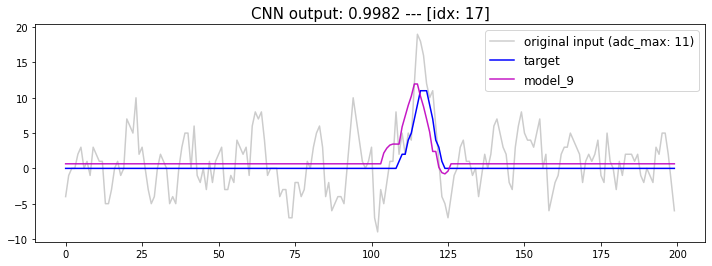

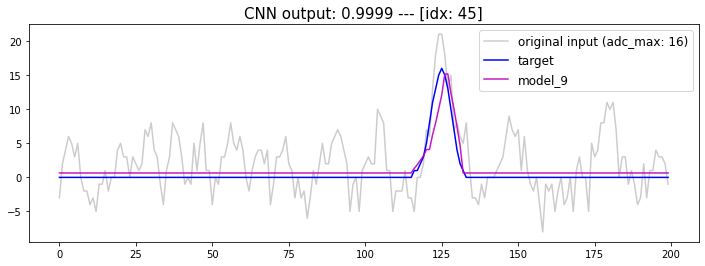

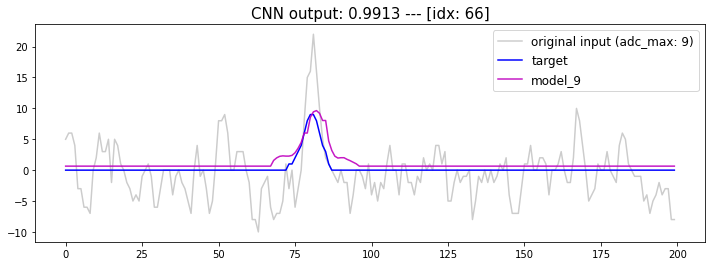

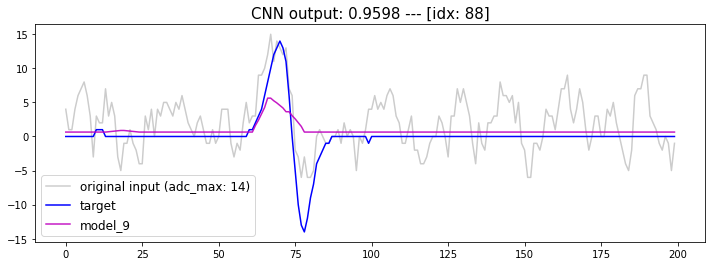

In [15]:
for index_ in range(100):
    max_adc = int((max(y_test_[index_])))
    if (max_adc < 20 and cnn_pred[index_] > 0.94 and sum(y_test_[index_]) > 0):

        fig = plt.subplots(figsize=(12, 4))
        plt.plot(x_test_[index_], color='black',alpha=0.2, label = 'original input (adc_max: ' + str(max_adc) + ')')
        plt.plot(y_test_[index_],color='blue', label='target', alpha=1)
        #axes[i].plot(pred8[index_],color='m',alpha=0.7, label='model_8')
        plt.plot(pred9[index_],color='m',alpha=0.9, label='model_9')
        plt.legend(fontsize=12)
        plt.title('CNN output: ' + str(round(cnn_pred[index_], 4)) + ' --- [idx: ' + str(index_) + ']', size=15)
        #plt.ylim(-1, 1)
        plt.show()

In [ ]:
for index_ in range(100):
    max_adc = int((max(y_test_[index_])))
    if (max_adc < 20 and cnn_pred[index_] > 0.94 and sum(y_test_[index_]) > 0):

        fig = plt.subplots(figsize=(12, 4))
        plt.plot(x_test_[index_], color='black',alpha=0.2, label = 'original input (adc_max: ' + str(max_adc) + ')')
        plt.plot(y_test_[index_],color='blue', label='target', alpha=1)
        #axes[i].plot(pred8[index_],color='m',alpha=0.7, label='model_8')
        plt.plot(pred9[index_],color='m',alpha=0.9, label='model_9')
        plt.legend(fontsize=12)
        plt.title('CNN output: ' + str(round(cnn_pred[index_], 4)) + ' --- [idx: ' + str(index_) + ']', size=15)
        plt.ylim(0, 1)
        plt.show()

### DEBUG -- apply ADC-CUT

save plots to PDF - only saving model 5, best so far

In [16]:
def make_single_pdf(wave_idx, pg_num, min_cnn, max_cnn):

    fig, axs = plt.subplots(3,2, figsize=(30, 18), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .375, wspace=.1)

    axes = axs.ravel()

    for i in range(6):
        index_ = i + wave_idx
        max_adc = int((max(y_test_[index_])))
        # if not (max_adc < 20 and cnn_pred[index_] > min_cnn and cnn_pred[index_] <= max_cnn and sum(y_test_[index_]) == 0):
        if not (max_adc < 20 and cnn_pred[index_] > min_cnn and cnn_pred[index_] <= max_cnn and sum(y_test_[index_]) == 0):
            while True:
                index_ += 1
                max_adc = int((max(y_test_[index_])))
                
                if (max_adc < 20 and cnn_pred[index_] > min_cnn and cnn_pred[index_] <= max_cnn and sum(y_test_[index_]) == 0):
                    break
        wave_idx = index_


        axes[i].plot(x_test_[index_], color='black',alpha=0.2, label = 'original input (adc_max: ' + str(max_adc) + ')')
        axes[i].plot(y_test_[index_],color='blue', label='target', alpha=1)
        #axes[i].plot(pred8[index_],color='m',alpha=0.7, label='model_8')
        axes[i].plot(pred9[index_],color='m',alpha=0.9, label='model_9')
        axes[i].legend(fontsize=12)
        axes[i].set_title('CNN output: ' + str(round(cnn_pred[index_], 4)) + ' --- [idx: ' + str(index_) + ']', size=15)
        axes[i].set_ylabel('ADC', size=12)


    plt.savefig('pdfs/tmp/plts_cnn_page' + str(pg_num) +  '.pdf',
                dpi=300,
                bbox_inches='tight', pad_inches=0.75)
    plt.close()

    return wave_idx

In [17]:
# creates and merges pdf, removes all single page pdfs from tmp folder
def make_complete_pdf(num_pages, min_cnn, max_cnn):
    wave_idx_ = 0
    page_num = 0

    while page_num < num_pages:
        wave_idx_ = make_single_pdf(wave_idx_, page_num, min_cnn, max_cnn) + 1
        page_num += 1

    merger = PdfMerger()
    path = 'pdfs/tmp/'
    pdf_files = [path+f for f in listdir(path) if (isfile(join(path, f)))]
    print(pdf_files)
    for pdf_file in pdf_files:
        #Append PDF files
        merger.append(pdf_file)
    merger.write('pdfs/lastest_plots/plts_' + wireplane + '_cnn_'+str(int(min_cnn*100)) + '-' + str(int(max_cnn*100)) + '_' + str(num_pages) +  'pages_NOISE.pdf')
    merger.close()

    for file in pdf_files:
        os.remove(file)

In [18]:
make_complete_pdf(10, 0.94, 1)

['pdfs/tmp/plts_cnn_page0.pdf', 'pdfs/tmp/plts_cnn_page1.pdf', 'pdfs/tmp/plts_cnn_page2.pdf', 'pdfs/tmp/plts_cnn_page3.pdf', 'pdfs/tmp/plts_cnn_page4.pdf', 'pdfs/tmp/plts_cnn_page5.pdf', 'pdfs/tmp/plts_cnn_page6.pdf', 'pdfs/tmp/plts_cnn_page7.pdf', 'pdfs/tmp/plts_cnn_page8.pdf', 'pdfs/tmp/plts_cnn_page9.pdf']


In [19]:
min_ = 0.94
prev = min_
max_ = 1
while min_ > 0:
    min_ = min_ - 0.2 
    make_complete_pdf(10, min_, prev)
    prev = min_


['pdfs/tmp/plts_cnn_page0.pdf', 'pdfs/tmp/plts_cnn_page1.pdf', 'pdfs/tmp/plts_cnn_page2.pdf', 'pdfs/tmp/plts_cnn_page3.pdf', 'pdfs/tmp/plts_cnn_page4.pdf', 'pdfs/tmp/plts_cnn_page5.pdf', 'pdfs/tmp/plts_cnn_page6.pdf', 'pdfs/tmp/plts_cnn_page7.pdf', 'pdfs/tmp/plts_cnn_page8.pdf', 'pdfs/tmp/plts_cnn_page9.pdf']
['pdfs/tmp/plts_cnn_page0.pdf', 'pdfs/tmp/plts_cnn_page1.pdf', 'pdfs/tmp/plts_cnn_page2.pdf', 'pdfs/tmp/plts_cnn_page3.pdf', 'pdfs/tmp/plts_cnn_page4.pdf', 'pdfs/tmp/plts_cnn_page5.pdf', 'pdfs/tmp/plts_cnn_page6.pdf', 'pdfs/tmp/plts_cnn_page7.pdf', 'pdfs/tmp/plts_cnn_page8.pdf', 'pdfs/tmp/plts_cnn_page9.pdf']
['pdfs/tmp/plts_cnn_page0.pdf', 'pdfs/tmp/plts_cnn_page1.pdf', 'pdfs/tmp/plts_cnn_page2.pdf', 'pdfs/tmp/plts_cnn_page3.pdf', 'pdfs/tmp/plts_cnn_page4.pdf', 'pdfs/tmp/plts_cnn_page5.pdf', 'pdfs/tmp/plts_cnn_page6.pdf', 'pdfs/tmp/plts_cnn_page7.pdf', 'pdfs/tmp/plts_cnn_page8.pdf', 'pdfs/tmp/plts_cnn_page9.pdf']
['pdfs/tmp/plts_cnn_page0.pdf', 'pdfs/tmp/plts_cnn_page1.pdf', 'pdf

## ----------------------------------------------------------------------------

#### generate plots of model's prediction on top of input & clean target (ADC CUT APPLIED)

In [ ]:
for idx in range(10):
    max_adc = int((max(x_test_[idx])))
    if sum(y_test_scaled[idx]) != 0:
        if max_adc > 20 and cnn_pred[idx] > 0.94:
            fig, (ax1) = plt.subplots(figsize=(15, 12), facecolor='white')
            ax1.plot(y_test_[idx],color='yellow', label='target', alpha=0.7)
            ax1.plot(x_test_[idx], color='black',alpha=0.2, label = 'original input (adc_max: ' + str(max_adc) + ')')

            #ax1.plot(pred0[idx],color='m',alpha=0.5, label='model_0')
            #ax1.plot(pred1[idx],color='g',alpha=0.3, label='model_1')
            #ax1.plot(pred2[idx],color='r',alpha=0.3, label='model_2')
            #ax1.plot(pred3[idx],color='yellow',alpha=0.3, label='model_3')
            #ax1.plot(pred4[idx],color='orange',alpha=0.5, label='model_4')
            ax1.plot(pred5[idx],color='m',alpha=0.9, label='model_5')
            #ax1.plot(pred6[idx],color='r',alpha=0.3, label='model_6')
            
            
            ax1.set_title("cnn output: " + str(round(cnn_pred[idx], 4)), fontsize=15)
            ax1.legend()
            #filename = 'plane_u_AE_plots_ADC_MAX_15_no_noise/'+str(idx)+'.png' 
            #plt.savefig(filename, facecolor='w'
            plt.show()

### DEBUG -- apply ADC-CUT -- NOT DONE

-----------------------------------------------------------------------------